In [106]:
import matplotlib
import sys
import gc
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import FormatStrFormatter
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors

# Para manejar los archivos y automatizar la lectura en directorios
import csv
import os
# Fontsize
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
# Latex font
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

%matplotlib inline

# Nombres de archivo, paths y definiciones
La informacion de redshift solo se encuentra en los halos lvl3 dado que se necesita mucha resolucion a alto redshift donde el halo es mas pequeno

In [107]:
# SOME DEFINITIONS
# The directory where information lies
direc = '../Data/Halo_Detail/'
# Level of the simulation 
lvl = 'level3_'
# If DM or MHD
sim_det = 'DM'

# la carpeta completa
lvl = lvl+sim_det

# Halos de la simulacion de nivel 3
halos = [6,16,21,23,24,27]
#halos = [24]

# Data format
El formato de la data se explica con la siguiente funcion

In [134]:
# En esta funcion se obtiene la data de un halo dadas sus especificaciones
# Parametros necesarios:
# directorio - el directorio donde se encuentran los datos
# level      - el nivel de la simulacion incluyendo si es DM o MHD
# halo       - el numero del halo
# Retorna:
# Una lista de arrays con el radial profile y su respectivo redshift
def get_data(directorio,level,halo):
    # El path en donde esta la informacion
    path = directorio+level+'/halo_'+str(halo)
    print('path', path)
    # List of directories
    # Cada radial profile esta en una carpeta diferente para redshift diferentes
    # Se obtienen las carpetas de los redshifts
    listdir = next(os.walk(path))[1]
    if 'rand_sample' in listdir:
        listdir.remove('rand_sample')
    # Retorna el numero del snapshot para ordenar
    def getkey(l):
        return int(l.split("_")[1])
    # ordena por numero de snapshot
    listdir.sort(key=getkey)
    #print(listdir)
    
    # La lista en la que se van a guardar los radial profiles
    list_radial_profiles = []
    # Obtiene la informacion para cada subdirectorio
    for sub_dir in listdir:
        # Loads information dictionary
        # Esta informacion es cargada en info.npy como un objeto de numpy
        # y se carga de la siguiente manera
        info = np.load(path+"/"+sub_dir+"/info.npy",encoding = 'latin1')
        # Por ahora solo queremos el redshift\
        # Pero contiene informacion del scale factor y los radios R_DM,R_BH y R_Star
        redshift = info.item().get('Redshift')
        #print("Redshift: "+str(redshift))
        
        #if redshift > 2:        
        # Semiaxes
        # Se cargan los semiejes en formato a,b,c 
        # el radio de sampleo es la media geometrica de abc
        filename = path+"/"+sub_dir+"/s"+sub_dir.split("_")[1]+".txt"
        arr = np.loadtxt(filename, delimiter = ",")
        print(filename)
        # anade la informacion

        list_radial_profiles.append([redshift,arr])
    
    return list_radial_profiles
    

# Usage
### Ejemplo de uso en el perfil radial en el redshift

In [109]:
# The geometric mean
from scipy.stats.mstats import gmean
# Fonts 
MEDIUM_SIZE = 30
SMALL_SIZE = 25
SSSMALL_SIZE = 17
plt.rc('font', size=SSSMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels

#halonums = [24]
with PdfPages("../Graphs/Redshift_"+lvl+".pdf") as pdf:
    for halo in halos:
        print(halo)

        # Load the ddata
        data_halo = get_data(direc,lvl,halo)
        #print(data_halo)

        # Plots    
        ylabel = ['b/a','c/a','T']
        fig, axs = plt.subplots(figsize=(10,15),nrows=3)

        # Color settings for redshift
        my_norm = colors.Normalize(0.0,0.4)
        mapa = cm.ScalarMappable(norm=my_norm, cmap="CMRmap")

        for redshift,axes in data_halo:
            print(redshift)
            # Axial ratios and radii (including rvir)
            # Cuidado con la dimension del array
            if axes.ndim > 1:
                a,b,c = axes[:-1].T
            else: 
                a,b,c = axes
            xvals = (a*b*c)**(1./3.)
            # Cantidades a plotear
            yvals = np.array([b/a,c/a,(a**2-b**2)/(a**2-c**2)])
            
            #print(yvals)
            # Virial rad
            rvir = 0
            # Cuidado con la dimension de los semiejes
            # a veces se tiene baja resolucion y es solo un datao para ejes
            if axes.ndim == 1:
                rvir = gmean(axes)
            else:
                rvir = gmean(axes[-1])

            mappable = 0
            # Hace la grafica para cada eje
            for ax,yval,ylab in zip(axs,yvals,ylabel):
                
                # Define el color para el redshift
                my_col = mapa.to_rgba(1.-(1.0/(1.0+redshift)))
                
                # para tener solo un label 
                if(redshift < 1e-6):
                    mappable = ax.plot(xvals,yval, color = my_col, linewidth=1, label = "Radial shape", alpha = 1,zorder=10)
                    ax.plot([rvir,rvir],[0,0.5], color = my_col, linestyle = '-.',label = r"$R_{500}$",zorder =1)
                else:
                    mappable = ax.plot(xvals,yval, color = my_col, linewidth=0.5,  alpha = 1,zorder = 10)
                    ax.plot([rvir,rvir],[0,0.5], color = my_col,linestyle = '-.',zorder=1)

                # Major ticks every 20, minor ticks every 5
                major_ticksy = np.linspace(0, 1, 3)
                minor_ticksy = np.linspace(0, 1, 11)
                major_ticksx = np.logspace(-1, 2, 3)
                minor_ticksx = np.logspace(-1, 2, 30)

                ax.set_xticks(major_ticksx)
                ax.set_xticks(minor_ticksx, minor=True)
                ax.set_yticks(major_ticksy)
                ax.set_yticks(minor_ticksy, minor=True)
                ax.grid(which='both')
                ax.grid(which='minor', alpha=0.3)
                ax.grid(which='major', alpha=0.6)
                
                # Log scale for radius
                ax.set_xscale('log')
                ax.set_ylabel(ylab)

                # Plotting ratios
                ax.set_ylim(0,1)

                # Axs specs
                ax.set_xlim(3,rvir+30)
                ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
                ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

                # Hide axes 
                plt.setp( ax.get_xticklabels(), visible=False)                


        # Axs specs  
        #axs[0].legend(loc='upper left', bbox_to_anchor=(1, 0.5))  

        xticks = [0, 0.5, 1, 2]
        yticks = [1.- 1.0/(1.0+x) for x in xticks]

        # Colorbar ax
        cbaxes = fig.add_axes([0.95, 0.1, 0.02, 0.8]) 
        cbar = mpl.colorbar.ColorbarBase(cbaxes, cmap = "CMRmap", norm = my_norm, orientation = 'vertical', ticks = yticks )  
        cbar.ax.set_yticklabels(xticks)
        cbar.set_label('$Redshift$', fontsize=30 )

        axs[-1].legend(loc = 0)
        axs[-1].set_xlabel("R(Kpc/h)")
        plt.setp( axs[-1].get_xticklabels(), visible=True)                
        #axs[0].set_title(halo+"  Rvir="+str(rvir)+"Kpc" )  
        #axs[0].set_title(halo)  

        pdf.savefig(fig, bbox_inches='tight')
        plt.close()

6
15.45026662890206
10.367443572408746


/Users/forero/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:40: RuntimeWarning: invalid value encountered in double_scalars


6.855117262650799
8.449476294368743
7.5951071498715965
6.855117262650799
6.144901203416368
5.5297658079491026
4.939380663491011
4.428033736605549
3.9372610847275835
3.4908613692606485
3.084822635834013
2.7331426173187188
2.4442257045541464
2.207925472383703
2.207925472383703
2.0020281392528516
2.0020281392528516
1.822689252620354
1.6666695561144653
1.5312390291576135
1.4140982203725216
1.3023784599059653
1.2062580807810006
1.1141505637653806
1.035510445664141
0.9505313515850327
0.8868969375752482
0.8167099790118506
0.7574413726158526
0.7001063537185233
0.6446418406845371
0.5985432881875667
0.5463921831410221
0.5030475232448832
0.4609177941806475
0.41996894199726653
0.38016786726023866
0.3478538418581776
0.31007412012783386
0.2733533465784399
0.24354018155467028
0.21442503551449454
0.1803852617057493
0.15274876890238098
0.12575933241126092
0.09940180263022191
0.07366138465643868
0.04852362998180593
0.023974428382762536
2.220446049250313e-16
16
15.45026662890206
10.367443572408746
6.8551

No handles with labels found to put in legend.


23
24
0.4609177941806475
0.41996894199726653
0.38016786726023866
0.3478538418581776
0.31007412012783386
0.2733533465784399
0.24354018155467028
0.21442503551449454
0.1803852617057493
0.15274876890238098
0.12575933241126092
0.09940180263022191
0.07366138465643868
0.04852362998180593
0.023974428382762536
2.220446049250313e-16


No handles with labels found to put in legend.


27


### Ejemplo de uso obteniendo el radio virial en funcion del redshift

path ../Data/Halo_Detail/level3_DM/halo_27


Text(0,0.5,'Rvir kpc')

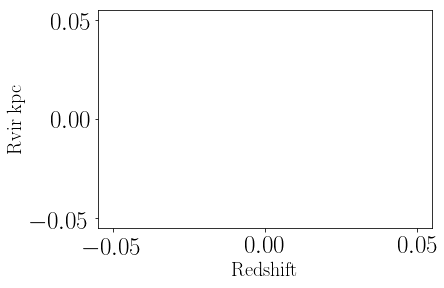

In [135]:
# The geometric mean
from scipy.stats.mstats import gmean

# El primer Halo
specific_halo = halos[5]
# Tomamos los datos
data_halo = get_data(direc,lvl,specific_halo)
# Vamos a plotear el radio virial (ultimo radio sampleado), en funcion del redshift
redshift = []
vir_rad = []
for red,axes in data_halo:
    redshift.append(red)
    rvir = 0
    # Cuidado con la dimension de los semiejes
    # a veces se tiene baja resolucion y es solo un datao para ejes
    if axes.ndim == 1:
        rvir = gmean(axes)
    else:
        rvir = gmean(axes[-1])
    vir_rad.append(rvir)
    
redshift = np.array(redshift)  
vir_rad = np.array(vir_rad)
indices = np.argsort(redshift)
plt.plot(redshift[indices],vir_rad[indices]*(redshift[indices]+1))
plt.xlabel('Redshift',fontsize =20)
plt.ylabel('Rvir kpc',fontsize =20)

# Data 2
Ademas de la estructura de datos anteriormente presentada, se tiene, para cada halo un resumen de la caracterizacion de triaxialidad en el radio virial y en funcion del redshift.

Esta se encuentra principalmente en el archivo Z_axes.txt, el cual tiene el formato:

Z,a,b,c 

Z2,a2,b2,c2

Z3,a3,b3,c3

Z4,a4,b4,c4
...

Con estos datos podremos reconstruir la historia del halo restringida al radio virial:

# Correlacion historico en radio virial vs radial en Z =0
# en el plano triaxial

In [117]:
# Keeps semiaxes and eigenvecs
def plot_halos(output_pdf, halos, sim_det='DM', lvl='level3_', side_bar=False):
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    MEDIUM_SIZE = 30
    SMALL_SIZE = 30
    SSSMALL_SIZE = 16

    plt.rc('font', size=SSSMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    direc = '../Data/Halo_Detail/'
    
    # Plots    
    figure = plt.figure(figsize=(9,30))
    # Recorre los halos
    for i_halo, j_halo in enumerate(halos):
        axs = plt.subplot(3,1,i_halo+1)
        sim_type = {"DM":"DMO", "MHD":"MHD"}
        # Halo name        
        halo = "halo_{:d}".format(j_halo)     
        print("------------------------------------"+halo)   
    
        # Paths to file
        path = direc+lvl+sim_det+"/"+halo
        
        # Loads redshift and axes abc at rvir
        arr = np.loadtxt(path+"/"+"Z_axes.txt", delimiter = ",")
        # Este es el formato del archivo
        redshift,a,b,c = arr.T  

        # Fonts 
        MEDIUM_SIZE = 30
        SMALL_SIZE = 25
        SSSMALL_SIZE = 20
        plt.rc('font', size=SSSMALL_SIZE)          # controls default text sizes
        plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
        plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
        plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        
     
        red_limit = 1.0
        # Color settings
        my_norm = colors.Normalize(0.0,1.0)
        mapa = cm.ScalarMappable(norm=my_norm, cmap='cool')      
        
        for j in range(len(a)):
            
            # Not that much history
            if redshift[j] > red_limit:
                continue
            print("Redshift: "+str(redshift[j]))
            # Plot scatter point
            # my_col = mapa.to_rgba(1.0-(1.0/(1.0+redshift[j])))
            my_col = mapa.to_rgba(redshift[j])

            if redshift[j] < 1e-6:
            
                axs.scatter(b[j]/a[j],c[j]/a[j], color = my_col, s=90, alpha = 1, zorder = len(a)-j,
                            label = r"${\mathrm{Historical\ shape}}\ R_{200}$")
            else:
                axs.scatter(b[j]/a[j],c[j]/a[j], color = my_col, s=90, alpha = 1, zorder = len(a)-j)
            
            if redshift[j+1] < red_limit:
                axs.plot([b[j]/a[j],b[j+1]/a[j+1]],[c[j]/a[j],c[j+1]/a[j+1]], color = my_col, linewidth=3, alpha = 1, zorder = len(a)-j)
                        
                
        # Plots last snapshot in terms of radius
        arr = np.loadtxt(path+"/"+"abc_"+lvl+sim_det+"_"+halo+".txt", delimiter = ",")
        a,b,c = (arr)[:-1].T
        rvir =  arr[-1][0]
        xvals = (a*b*c)**(1./3.)
        # Axial ratios and radii (including rvir)
        a,b,c = (arr[:-1][xvals>=1]).T
        xvals = (a*b*c)**(1./3.)
        
        # Radius at which comparison is performed (in kpc)
        #axs.plot((b/a)[xvals>rvir],(c/a)[xvals>rvir], color = 'black', linewidth=2, alpha = 1, linestyle = "--", zorder = len(a), label='QSO')
        axs.plot((b/a)[xvals<rvir/2],(c/a)[xvals<rvir/2], color = 'black', linewidth=2, alpha = 1, linestyle = "--", zorder = len(a),label="Radial shape z = 0")
    
        # Axs specs
        axs.plot([0,1],[0,1], linewidth= 2, c = 'black')
        axs.set_xlabel("b/a")
        axs.set_ylabel("c/a")
        axs.set_title("Halo {} - {}".format(j_halo, sim_type[sim_det]))
        
         # grid!!
        # Major ticks every 20, minor ticks every 5
        major_ticksy = np.linspace(0, 1, 3)
        minor_ticksy = np.linspace(0, 1, 11)

        axs.set_xticks(major_ticksy)
        axs.set_xticks(minor_ticksy, minor=True)
        axs.set_yticks(major_ticksy)
        axs.set_yticks(minor_ticksy, minor=True)
        axs.grid(which='both')
        axs.grid(which='minor', alpha=0.3)
        axs.grid(which='major', alpha=0.6)

        axs.set_xlim(0,1)
        axs.set_ylim(0,1)
        #axs.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        
        # Colorbar
        xticks = [0, 0.25, 0.5, 0.75, 1]
        yticks = [x for x in xticks]

        if side_bar:
            # Colorbar ax
            cbaxes = figure.add_axes([0.95, 0.1, 0.02, 0.8]) 
        
            axs.legend(loc=0)
            cbar = mpl.colorbar.ColorbarBase(cbaxes, cmap = "cool", norm = my_norm, orientation = 'vertical', ticks = yticks )  
            cbar.ax.set_yticklabels(xticks)
            cbar.set_label(r'${\mathrm{Redshift}}$', fontsize=30 )
        
    # Save
    plt.savefig(output_pdf, bbox_inches='tight')

------------------------------------halo_6
Redshift: 2.220446049250313e-16
Redshift: 0.009521666967944764
Redshift: 0.023974428382762536
Redshift: 0.0337243718735154
Redshift: 0.04852362998180593
Redshift: 0.058507322794512984
Redshift: 0.07366138465643868
Redshift: 0.08388443079747931
Redshift: 0.09940180263022191
Redshift: 0.10986994045882548
Redshift: 0.12575933241126092
Redshift: 0.14187620396956202
Redshift: 0.15274876890238098
Redshift: 0.1692520332436107
Redshift: 0.1803852617057493
Redshift: 0.19728418237600986
Redshift: 0.21442503551449454
Redshift: 0.22598838626019768
Redshift: 0.24354018155467028
Redshift: 0.2613432561610123
Redshift: 0.2733533465784399
Redshift: 0.29158323972192446
Redshift: 0.31007412012783386
Redshift: 0.32882972420595435
Redshift: 0.3478538418581776
Redshift: 0.36068765726181673
Redshift: 0.38016786726023866
Redshift: 0.3999269646135635
Redshift: 0.41996894199726653
Redshift: 0.4402978492477432
Redshift: 0.4609177941806475
Redshift: 0.4818329434209512
Re

/Users/forero/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Redshift: 0.07366138465643868
Redshift: 0.08388443079747931
Redshift: 0.09940180263022191
Redshift: 0.10986994045882548
Redshift: 0.12575933241126092
Redshift: 0.14187620396956202
Redshift: 0.15274876890238098
Redshift: 0.1692520332436107
Redshift: 0.1803852617057493
Redshift: 0.19728418237600986
Redshift: 0.21442503551449454
Redshift: 0.22598838626019768
Redshift: 0.24354018155467028
Redshift: 0.2613432561610123
Redshift: 0.2733533465784399
Redshift: 0.29158323972192446
Redshift: 0.31007412012783386
Redshift: 0.32882972420595435
Redshift: 0.3478538418581776
Redshift: 0.36068765726181673
Redshift: 0.38016786726023866
Redshift: 0.3999269646135635
Redshift: 0.41996894199726653
Redshift: 0.4402978492477432
Redshift: 0.4609177941806475
Redshift: 0.4818329434209512
Redshift: 0.5030475232448832
Redshift: 0.524565820433923
Redshift: 0.5463921831410221
Redshift: 0.5759808451078874
Redshift: 0.5985432881875667
Redshift: 0.6214287452425136
Redshift: 0.6446418406845371
Redshift: 0.676110411213477

/Users/forero/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Redshift: 0.41996894199726653
Redshift: 0.4402978492477432
Redshift: 0.4609177941806475
Redshift: 0.4818329434209512
Redshift: 0.5030475232448832
Redshift: 0.524565820433923
Redshift: 0.5463921831410221
Redshift: 0.5759808451078874
Redshift: 0.5985432881875667
Redshift: 0.6214287452425136
Redshift: 0.6446418406845371
Redshift: 0.6761104112134777
Redshift: 0.7001063537185233
Redshift: 0.7326361820223115
Redshift: 0.7574413726158526
Redshift: 0.7910682489463392
Redshift: 0.8167099790118506
Redshift: 0.8514709006246495
Redshift: 0.8868969375752482
Redshift: 0.9230008161779089
Redshift: 0.9505313515850327
Redshift: 0.987852810815766
------------------------------------halo_6
Redshift: 2.220446049250313e-16
Redshift: 0.023974428382762536
Redshift: 0.04852362998180593
Redshift: 0.07366138465643868
Redshift: 0.09940180263022191
Redshift: 0.12575933241126092
Redshift: 0.15274876890238098
Redshift: 0.1803852617057493
Redshift: 0.21442503551449454
Redshift: 0.24354018155467028
Redshift: 0.273353

/Users/forero/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


------------------------------------halo_21
Redshift: 2.220446049250313e-16
Redshift: 0.023974428382762536
Redshift: 0.04852362998180593
Redshift: 0.07366138465643868
Redshift: 0.09940180263022191
Redshift: 0.12575933241126092
Redshift: 0.15274876890238098
Redshift: 0.1803852617057493
Redshift: 0.21442503551449454
Redshift: 0.24354018155467028
Redshift: 0.2733533465784399
Redshift: 0.31007412012783386
Redshift: 0.3478538418581776
Redshift: 0.38016786726023866
Redshift: 0.41996894199726653
Redshift: 0.4609177941806475
Redshift: 0.5030475232448832
Redshift: 0.5463921831410221
Redshift: 0.5985432881875667
Redshift: 0.6446418406845371
Redshift: 0.7001063537185233
Redshift: 0.7574413726158526
Redshift: 0.8167099790118506
Redshift: 0.8868969375752482
Redshift: 0.9505313515850327
------------------------------------halo_23
Redshift: 2.220446049250313e-16
Redshift: 0.023974428382762536
Redshift: 0.04852362998180593
Redshift: 0.07366138465643868
Redshift: 0.09940180263022191
Redshift: 0.1257593

/Users/forero/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Redshift: 0.12575933241126092
Redshift: 0.15274876890238098
Redshift: 0.1803852617057493
Redshift: 0.21442503551449454
Redshift: 0.24354018155467028
Redshift: 0.2733533465784399
Redshift: 0.31007412012783386
Redshift: 0.3478538418581776
Redshift: 0.38016786726023866
Redshift: 0.41996894199726653
Redshift: 0.4609177941806475
Redshift: 0.5030475232448832
Redshift: 0.5463921831410221
Redshift: 0.5985432881875667
Redshift: 0.6446418406845371
Redshift: 0.7001063537185233
Redshift: 0.7574413726158526
Redshift: 0.8167099790118506
Redshift: 0.8868969375752482
Redshift: 0.9505313515850327


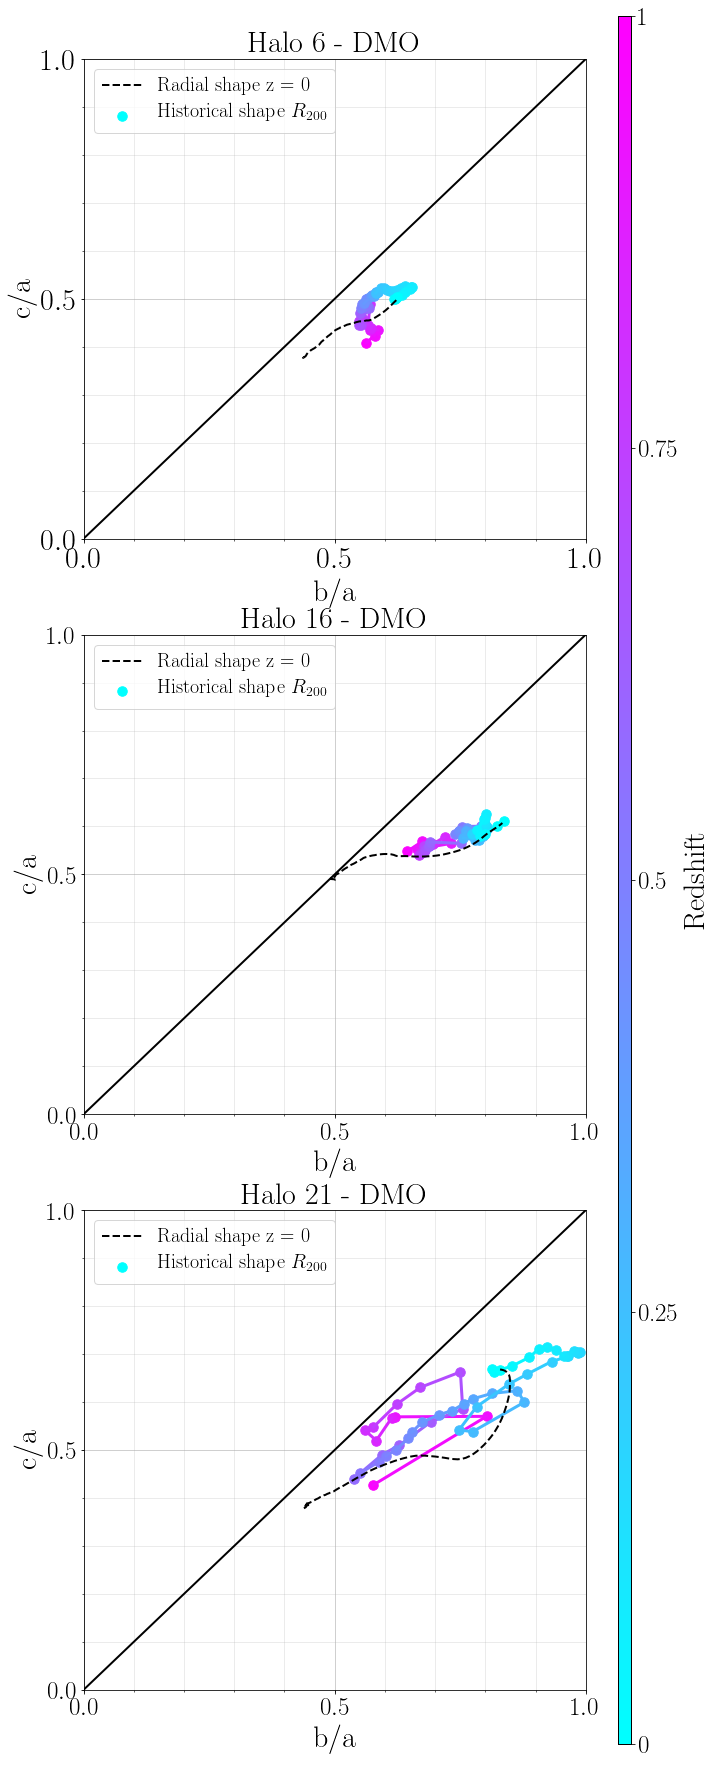

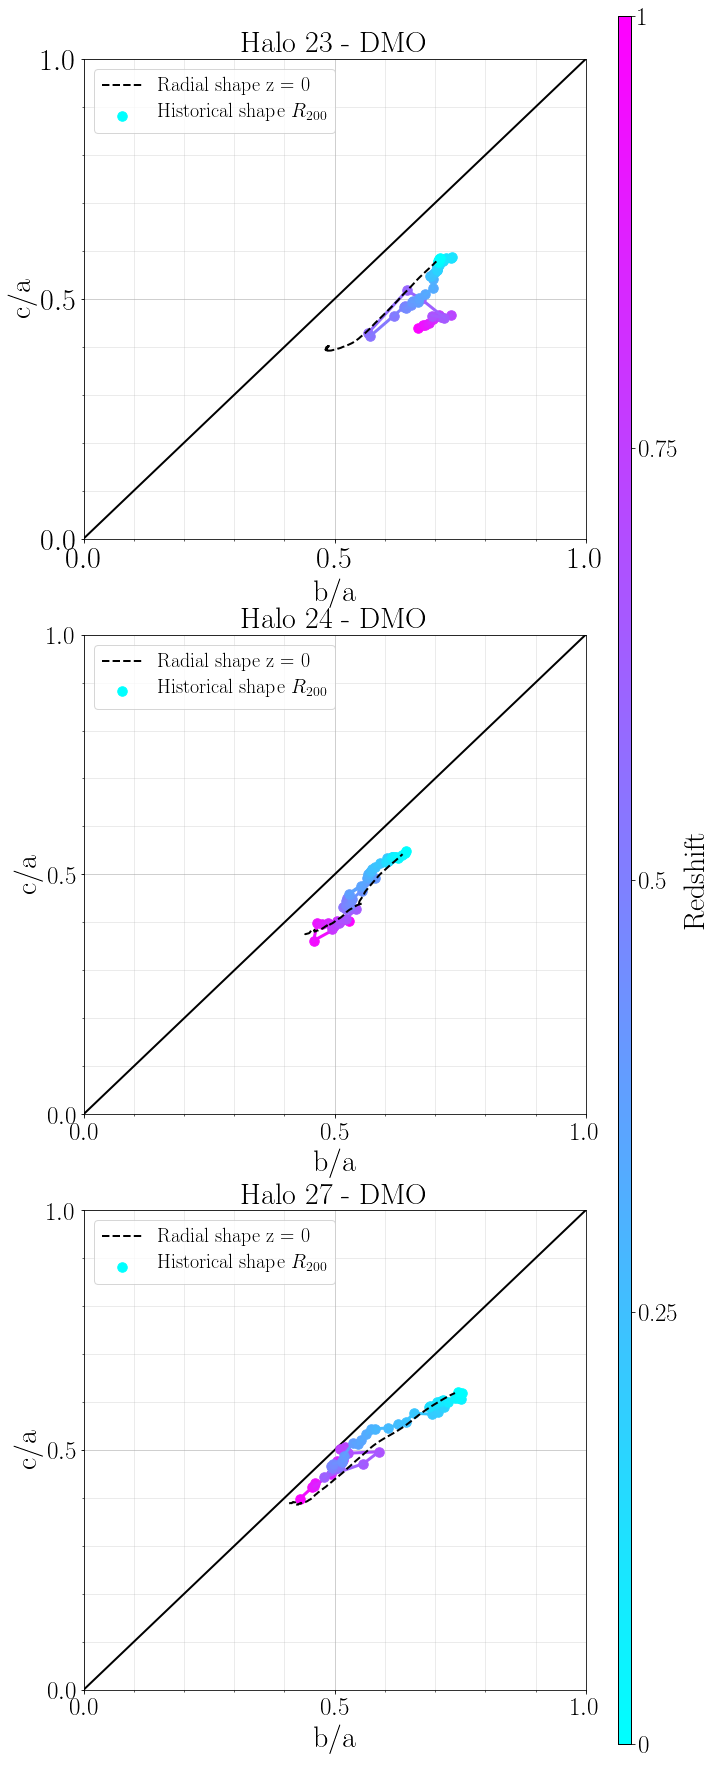

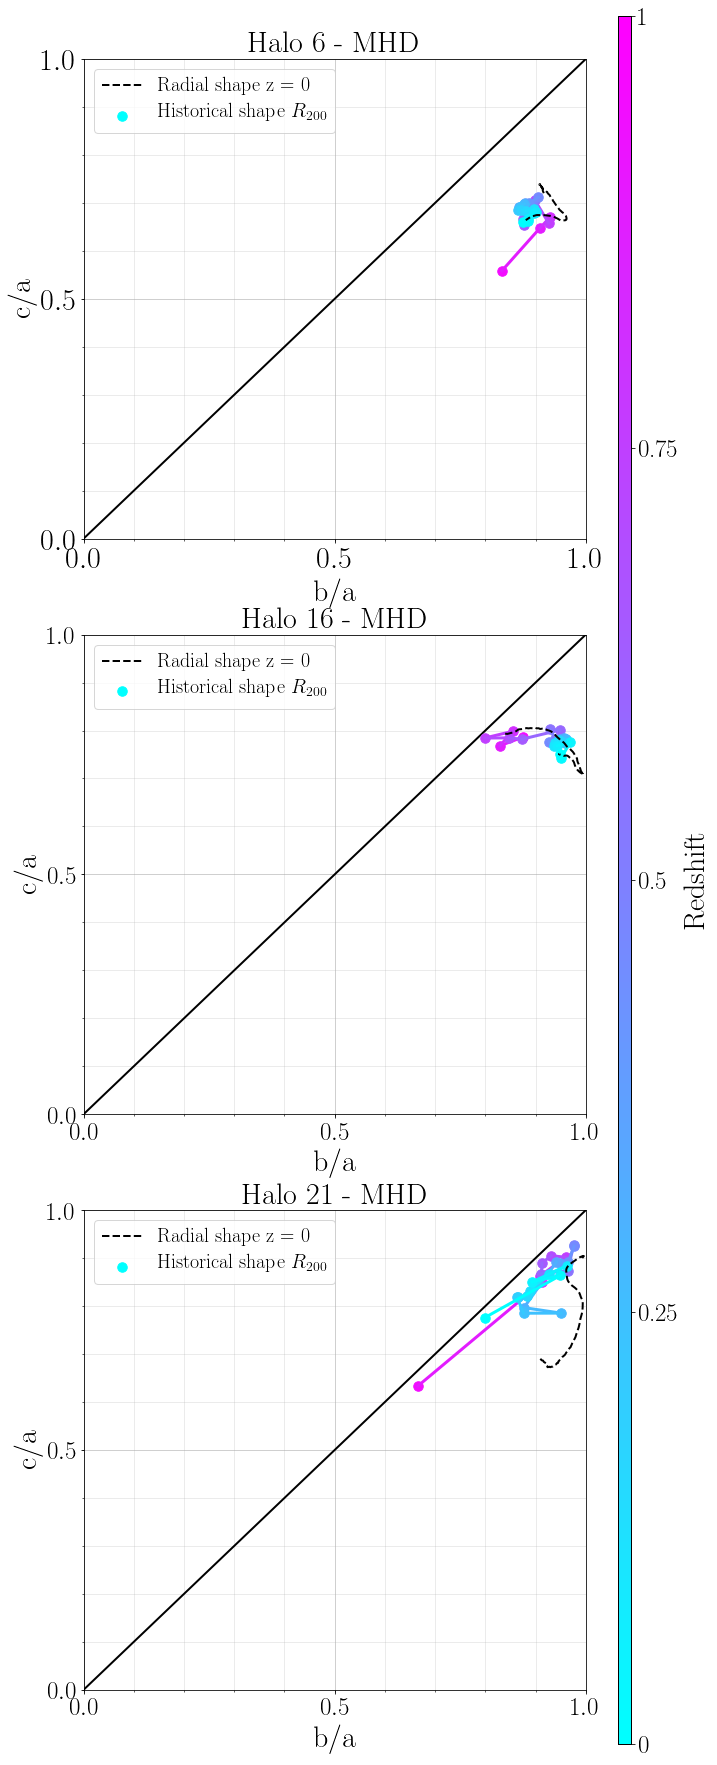

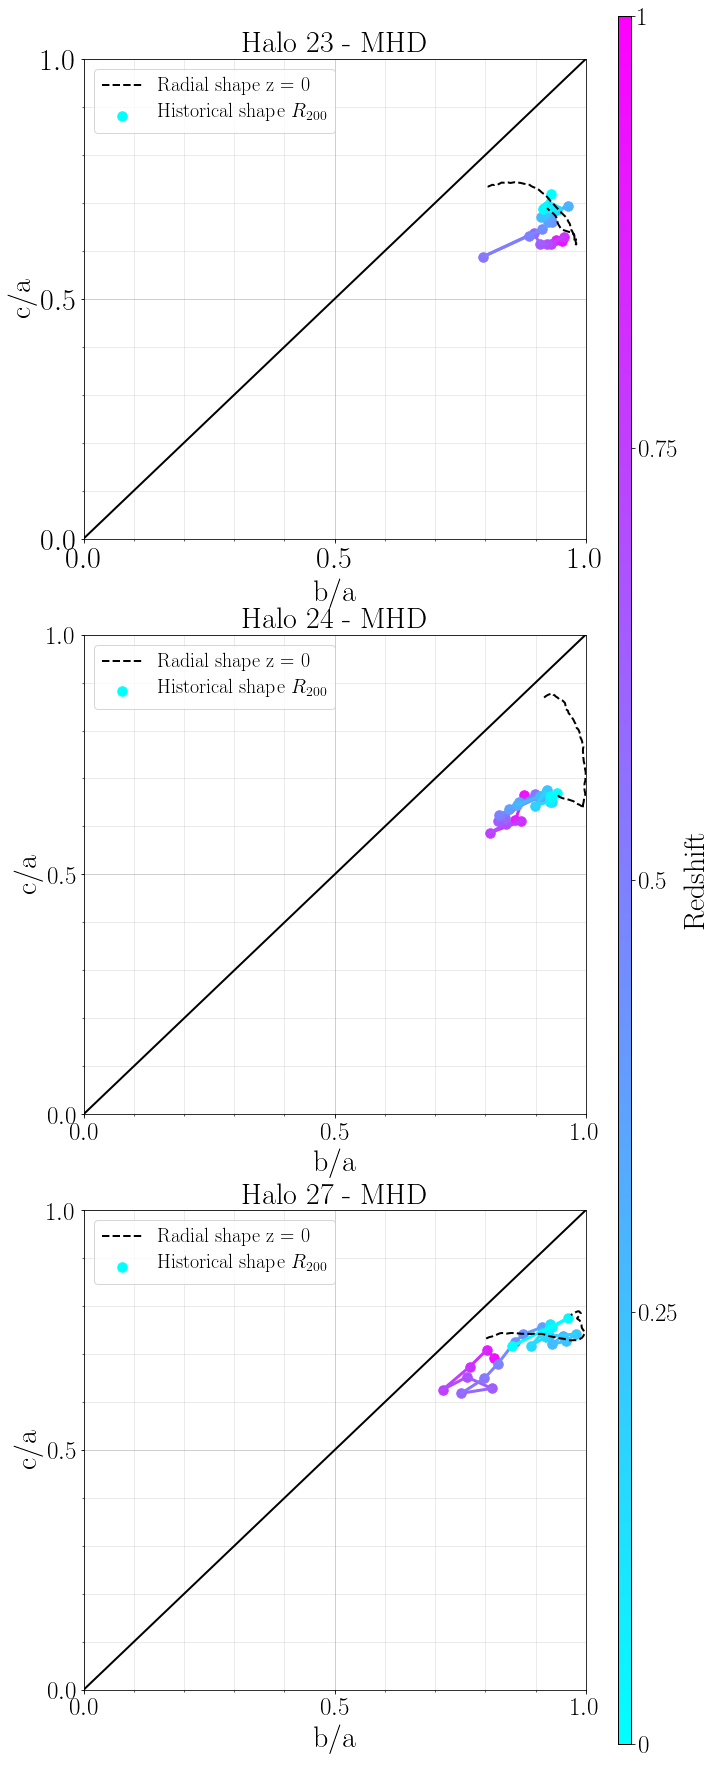

In [118]:
plot_halos("../Document/Z_Triax_level3_set_A_DM.pdf", halos = [6,16,21], sim_det='DM', side_bar=True)
plot_halos("../Document/Z_Triax_level3_set_B_DM.pdf", halos = [23,24,27], sim_det='DM', side_bar=True)
plot_halos("../Document/Z_Triax_level3_set_A_MHD.pdf", halos = [6,16,21], sim_det='MHD', side_bar=True)
plot_halos("../Document/Z_Triax_level3_set_B_MHD.pdf", halos = [23,24,27], sim_det='MHD', side_bar=True)